In [15]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import netCDF4 as nc
import xarray as xr
from scipy.linalg import eig
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

### Compare SLP of observations (GMSLP from former exercises) with PUMA data.

Does PUMA reproduce features of observations?

To this end, run PUMA for 92 years, take out december months and compare 
mean(SLP) and first and second EOF for regions:
Euroatlantic and Tropics.

In [2]:
path = "/home/rpinto/Downloads/WS21/KlimaDynamics/Exercises/Klimadynamics/data/"

In [3]:
with xr.open_dataset(path + "burn_puma_.nc", decode_times=False) as ds:
    print(ds.keys()) #puma simulation for this example has no orography or annual cyclces. 

KeysView(<xarray.Dataset>
Dimensions:  (lat: 32, lev: 1, lon: 64, time: 33120)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 85.76 80.27 74.74 69.21 ... -74.74 -80.27 -85.76
  * lev      (lev) float64 1e+03
  * time     (time) float64 0.0 1.0 2.0 3.0 ... 3.312e+04 3.312e+04 3.312e+04
Data variables:
    psl      (time, lat, lon) float32 ...
Attributes:
    title:        PUMA/PLASIM DATA
    history:      Created by PumaBurner 7.4
    Conventions:  CF-1.0)


In [4]:
dates = xr.cftime_range(start='0001', periods=33120, freq='1D', calendar='360_day') 
ds = ds.assign_coords(time=('time', dates))

In [5]:
slp_djf = ds.sel(time=ds['time.season']=='DJF').groupby('time.year').mean('time')

In [16]:
tropics = True

In [17]:
if tropics:
    slp_reg = slp_djf.isel(lat=(slp_djf.lat <= 20) & (slp_djf.lat >= -20))
else:
    slp_reg = slp_djf.isel(lat=(slp_djf.lat <= 70) & (slp_djf.lat >= 20),
                           lon=(slp_djf.lon >= 360-80) | (slp_djf.lon <= 20))

In [18]:
slp_reg

<xarray.Dataset>
Dimensions:  (lat: 8, lev: 1, lon: 64, year: 92)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 19.38 13.84 8.307 2.769 -2.769 -8.307 -13.84 -19.38
  * lev      (lev) float64 1e+03
  * year     (year) int64 1 2 3 4 5 6 7 8 9 10 ... 83 84 85 86 87 88 89 90 91 92
Data variables:
    psl      (year, lat, lon) float32 1011.9087 1011.9605 ... 1003.2449

In [19]:
n_lat = len(slp_reg.lat)
n_lon = len(slp_reg.lon)
m = len(slp_reg.year)
dim_new = (m, n_lat*n_lon)

In [20]:
slp_reg_stack = slp_reg.stack(latlon=('lat', 'lon'))

# weights
W = np.diag(np.sqrt(np.cos(np.deg2rad(slp_reg_stack.latlon.lat))))

# calculate covariance matrix
# calculate anomalies D and weigh them
D = slp_reg_stack - slp_reg_stack.mean('year')
D_weighted = D.psl.values @ W

cov_mat = (1/m) * D.psl.T.values @ D.psl.values
cov_mat_weighted = (1/m) * D_weighted.T @ D_weighted

In [21]:
# PCA
# calculate eigenvec and eigenval
# column eig_val[:,i] is the eigenvector corresponding to the eigenvalue eig_vec[i]
l, E = eig(cov_mat_weighted)  # eigen_val, eigen_vec
l = l.real
E = E.real

ix = np.argsort(l)
l = l[ix][::-1]
E = E[:, ix][:, ::-1]

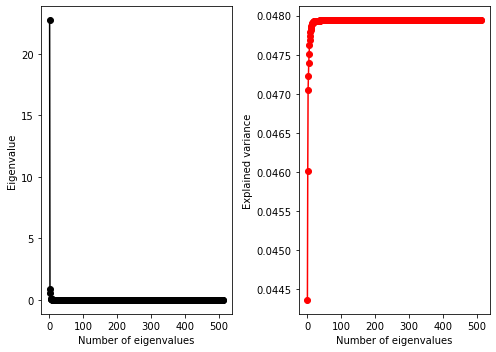

In [22]:
fig, [ax1, ax2] = plt.subplots(1, 2, figsize=(7, 5), sharex=True)

# plot eigenvalues
ax1.plot(range(1, 1+len(l)), l, 'ok-')
ax1.set_ylabel('Eigenvalue')
ax1.set_xlabel('Number of eigenvalues')

# plot explained variance
ex_var = np.cumsum(l)/len(l)
ax2.plot(range(1, 1+len(l)), ex_var, 'or-')
ax2.set_ylabel('Explained variance')
ax2.set_xlabel('Number of eigenvalues')

fig.tight_layout()

22.713637689964802 22.713637690515085
0.8456398534742122 0.8456398643228538


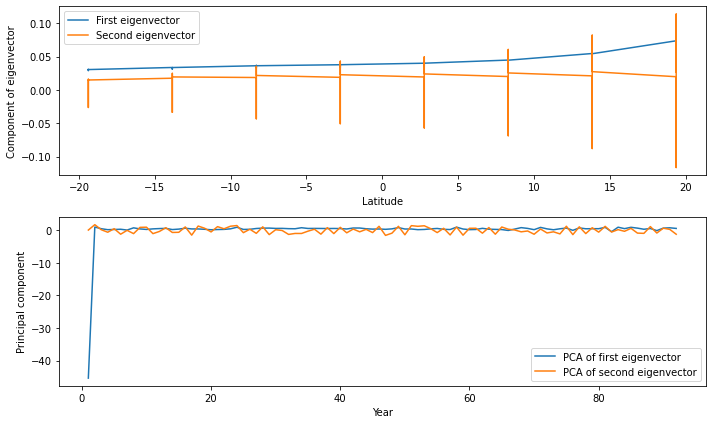

In [23]:
# plot first two eigenvalues
fig, [ax1,ax2] = plt.subplots(2, 1, figsize=(10,6))

# first and second eigenvector
ax1.plot(D.lat.values, E[:, 0], label='First eigenvector')
ax1.plot(D.lat.values, E[:, 1], label='Second eigenvector')
ax1.legend()
ax1.set_xlabel('Latitude')
ax1.set_ylabel('Component of eigenvector')

# principle components of first and second eigenvector
# calculate principle components (A) using the time series as X
A = E.T @ D_weighted.T  # principal components

for i in range(2):
    print(np.var(A[i, :]), l[i])

ax2.plot(D.year.values, A[0, :], label='PCA of first eigenvector')
ax2.plot(D.year.values, A[1, :], label='PCA of second eigenvector')
ax2.legend()
ax2.set_xlabel('Year')
ax2.set_ylabel('Principal component')

fig.tight_layout()

<ipython-input-14-cc45d9f1a445>:27: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  fig.tight_layout()


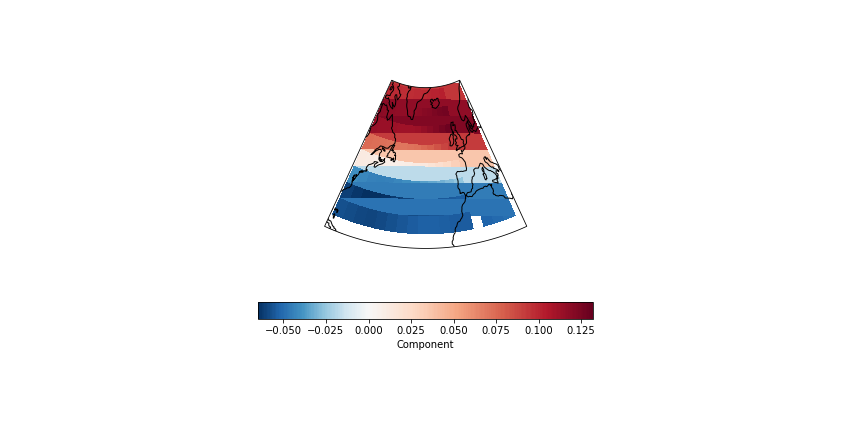

In [14]:
#plot ith eigenvector on map

i = 1 
  
fig = plt.figure(figsize=(15,15))
proj = ccrs.AlbersEqualArea(central_longitude=-30, central_latitude=40, standard_parallels=(0, 80))

ax = fig.add_subplot(111, projection=proj)    
ax.set_extent([-80, 20, 20, 70], ccrs.PlateCarree())    # set boundary

import matplotlib.path as mpath

vertices = [(lon, 20) for lon in range(-80, 21, 1)] + \
           [(lon, 70) for lon in range(20, -81, -1)]
boundary = mpath.Path(vertices)

ax.set_boundary(boundary, transform=ccrs.PlateCarree())    
norm = mcolors.TwoSlopeNorm(vmin=np.min(E[:, i-1]), vcenter=0, vmax=np.max(E[:, i-1]))
kwargs = dict(shading='auto', norm=norm, cmap='RdBu_r', transform=ccrs.PlateCarree())    

#corr_val, ll = add_cyclic_point(corr.T, coord= ds.lon)    
im = ax.pcolormesh(slp_reg.lon, slp_reg.lat, E[:, i-1].reshape((n_lat, n_lon))  , **kwargs)    
ax.coastlines()
#ax.set_title('Eigenvector {}'.format(i))
ax.set_global()    
fig.colorbar(im, ax=ax, orientation='horizontal', shrink=0.4, label='Component', pad=-0.15)
plt.show()

The tropics would not show ENSO as the simulation is a dry only simulation, therefore unable to caputre the latent heat fluxes over the tropics?

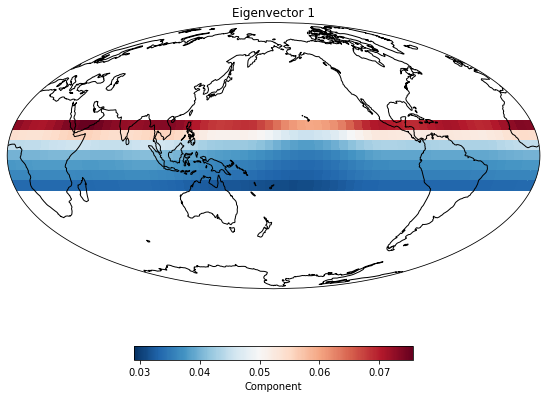

In [33]:
#%% plot ith eigenvector on map
i = 1  # number of eigenvector

proj = ccrs.Mollweide(central_longitude=180)

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection=proj)

norm = mcolors.TwoSlopeNorm(vmin=np.min(E[:, i-1]), vcenter=0.05, vmax=np.max(E[:, i-1]))
kwargs = dict(shading='nearest', norm=norm, cmap='RdBu_r', transform=ccrs.PlateCarree())

new_field, new_lon = add_cyclic_point(E[:, i-1].reshape((n_lat, n_lon)), coord=slp_reg.lon) 

im = ax.pcolormesh(new_lon, slp_reg.lat, new_field, **kwargs)

ax.coastlines()
ax.set_title('Eigenvector {}'.format(i))
ax.set_global()

fig.colorbar(im, ax=ax, orientation='horizontal', shrink=0.5, label='Component')